In [1]:
import json
from os import path

import matplotlib.pyplot as plt
import torch
from pandas import DataFrame
from seaborn import heatmap
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader
from torchvision.datasets.folder import ImageFolder
from torchvision.transforms import Resize, CenterCrop, ToTensor, Compose, Normalize

from shared import BASE_DIR, CLASSES, get_resnext_model, training_device, get_xgboost_model, get_metrics, get_svm_model

test_set = ImageFolder(path.join(BASE_DIR, "test"), transform=Compose([
    Resize(256),
    CenterCrop(224),
    ToTensor(),
    Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
]))
test_loader = DataLoader(test_set, batch_size=12, shuffle=True, num_workers=8)


def resnext_stats():
    predictions = []
    corrects = []

    model = get_resnext_model()
    for inputs, labels in test_loader:
        output = model(inputs.to(training_device()))
        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        predictions.extend(output)

        labels = labels.data.cpu().numpy()
        corrects.extend(labels)

    cm = confusion_matrix(corrects, predictions, normalize="true")
    cm_df = DataFrame(cm, index=[i for i in CLASSES], columns=[i for i in CLASSES])

    plt.figure()
    heatmap(cm_df, annot=True)
    plt.savefig("resnext_confusion_matrix.png")

    metrics = get_metrics(len(test_set.classes), torch.as_tensor(predictions), torch.as_tensor(corrects))
    with open("resnext_metrics.json", "w") as f:
        json.dump(metrics, f)


def xgboost_stats():
    predictions = []
    corrects = []

    model = get_xgboost_model()
    extractor = get_resnext_model()

    for inputs, labels in test_loader:
        output = extractor(inputs.to(training_device()))
        prediction = model.predict(output.detach().cpu())

        predictions.extend(prediction)

        labels = labels.data.cpu().numpy()
        corrects.extend(labels)

    cm = confusion_matrix(corrects, predictions, normalize="true")
    cm_df = DataFrame(cm, index=[i for i in CLASSES], columns=[i for i in CLASSES])

    plt.figure()
    heatmap(cm_df, annot=True)
    plt.savefig("xgboost_confusion_matrix.png")

    metrics = get_metrics(len(test_set.classes), torch.as_tensor(predictions), torch.as_tensor(corrects))
    with open("xgboost_metrics.json", "w") as f:
        json.dump(metrics, f)


def svm_stats():
    predictions = []
    corrects = []

    svm = get_svm_model()
    extractor = get_resnext_model()

    for inputs, labels in test_loader:
        output = extractor(inputs.to(training_device()))
        prediction = svm.predict(output.detach().cpu())

        predictions.extend(prediction)

        labels = labels.data.cpu().numpy()
        corrects.extend(labels)

    cm = confusion_matrix(corrects, predictions, normalize="true")
    cm_df = DataFrame(cm, index=[i for i in CLASSES], columns=[i for i in CLASSES])

    plt.figure()
    heatmap(cm_df, annot=True)
    plt.savefig("svm_confusion_matrix.png")

    metrics = get_metrics(len(test_set.classes), torch.as_tensor(predictions), torch.as_tensor(corrects))
    with open("svm_metrics.json", "w") as f:
        json.dump(metrics, f)

{'Sensitivity': 0.6600112915039062, 'Specificity': 0.9040851593017578, 'Precision': 0.666757345199585, 'F1-Score': 0.6502974033355713, 'Accuracy': 0.6600112915039062}


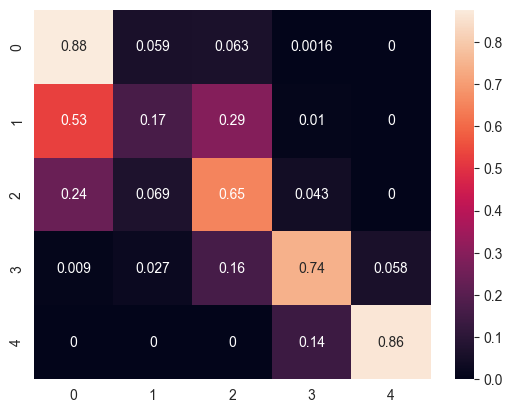

In [2]:
resnext_stats()

{'Sensitivity': 0.6615966558456421, 'Specificity': 0.9051055908203125, 'Precision': 0.6608529686927795, 'F1-Score': 0.6586204171180725, 'Accuracy': 0.6615966558456421}


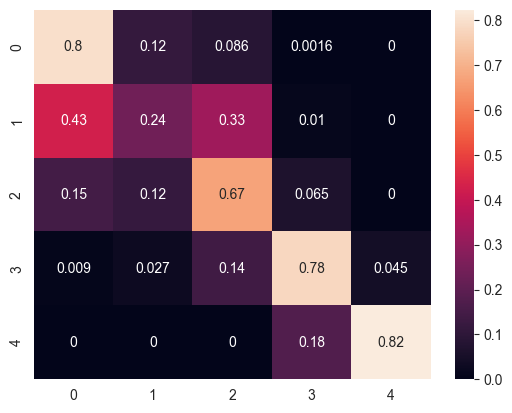

In [3]:
xgboost_stats()

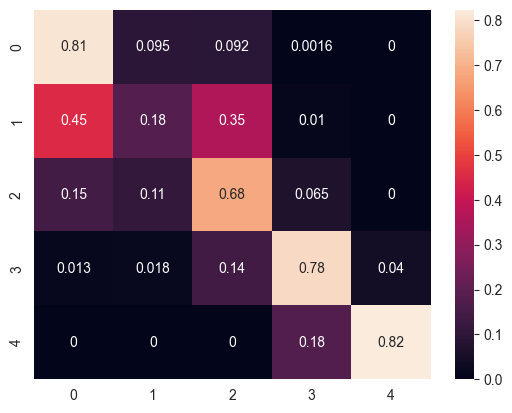

In [2]:
svm_stats()

In [ ]:
from torch.utils.tensorboard import SummaryWriter
from matplotlib import pyplot

model = get_resnext_model()

writer = SummaryWriter()

pyplot.title("Loss / Mean Squared Error")
pyplot.plot(history.history["loss"], label="train")
pyplot.plot(history.history["val_loss"], label="test")
pyplot.legend()
pyplot.show()